# Combining datasets to create our master dataset.

This notebook can be used to explore different options for combining our data. 

### Loading and preprocessing the HPSA dataset.

In [74]:
import time, os, math, numpy as np, pandas as pd, sklearn as sk, matplotlib as plt
# import sqlite3
from pandasql import sqldf
import seaborn as sns
pysqldf = lambda q: sqldf(q, globals())

In [75]:
# Load dataset for all Primary Care HPSA destinations with one record per facility
df_hpsa_pc = pd.read_csv("data/hpsa/BCD_HPSA_FCT_DET_PC.csv")

In [76]:
# q = """SELECT * 
#        FROM df_hpsa_pc
#        LIMIT 10;"""

# pysqldf(q)

In [77]:
print("Unique HPSA IDs: " + str(df_hpsa_pc['HPSA ID'].nunique()))
print("Unique Zip Codes: " + str(df_hpsa_pc["Common Postal Code"].nunique()))
print("Unique Cities: " + str(df_hpsa_pc["HPSA City"].nunique()))
print("Unique Counties " + str(df_hpsa_pc["Common County Name"].nunique()))

Unique HPSA IDs: 15939
Unique Zip Codes: 4557
Unique Cities: 3319
Unique Counties 3210


In [78]:
df_hpsa_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66858 entries, 0 to 66857
Data columns (total 66 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   HPSA Name                                                                 66858 non-null  object 
 1   HPSA ID                                                                   66858 non-null  object 
 2   Designation Type                                                          66858 non-null  object 
 3   HPSA Discipline Class                                                     66858 non-null  object 
 4   HPSA Score                                                                66858 non-null  int64  
 5   PC MCTA Score                                                             21358 non-null  float64
 6   Primary State Abbreviation                                    

In [79]:
df_hpsa_pc['Designation Type'].value_counts()

Designation Type
HPSA Population                                                                31873
Geographic HPSA                                                                23350
High Needs Geographic HPSA                                                      4366
Rural Health Clinic                                                             2970
Federally Qualified Health Center                                               1579
Indian Health Service, Tribal Health, and Urban Indian Health Organizations     1181
Correctional Facility                                                            991
Federally Qualified Health Center Look A Like                                    296
Other Facility                                                                   252
Name: count, dtype: int64

In [80]:
df_hpsa_pc.nunique().reset_index().sort_values(by=0, ascending=False).head(20)

,index,0
36,HPSA Component Name,38080
11,HPSA Geography Identification Number,36085
1,HPSA ID,15939
0,HPSA Name,14177
15,HPSA Designation Population,11432
37,HPSA Component Source Identification Number,7269
43,HPSA Estimated Underserved Population,6617
21,Latitude,6421
20,Longitude,6420
34,HPSA Address,6147


In [89]:
locations = df_hpsa_pc[["Common County Name","HPSA Geography Identification Number", 'HPSA City', 'HPSA Component Name', 'HPSA Component Source Identification Number']]
locations.head()

,Common County Name,HPSA Geography Identification Number,HPSA City,HPSA Component Name,HPSA Component Source Identification Number
0,"Lucas County, OH",39095004800,NaN,"Census Tract 48, Lucas County, Ohio",NaN
1,"Lucas County, OH",39095004600,NaN,"Census Tract 46, Lucas County, Ohio",NaN
2,"Lucas County, OH",39095004701,NaN,"Census Tract 47.01, Lucas County, Ohio",NaN
3,"Noble County, OH",POINT,Caldwell,Noble Correctional Institution,1396293612
4,"Williams County, OH",POINT,Edgerton,EDGERTON FAMILY HEALTH CENTER,1396199989


In [91]:
locations[locations['Common County Name'].str.contains('AL')]  0107000-01073001400

,Common County Name,HPSA Geography Identification Number,HPSA City,HPSA Component Name,HPSA Component Source Identification Number
17821,"Tallapoosa County, AL",01123962400,NaN,9624,NaN
17822,"Tallapoosa County, AL",01123962600,NaN,9626,NaN
17823,"Tallapoosa County, AL",01123962300,NaN,9623,NaN
17824,"Washington County, AL",01129,NaN,Washington,NaN
17825,"St. Clair County, AL",POINT,Springville,St. Clair Correctional Facility,1013634996
...,...,...,...,...,...
59541,"Covington County, AL",01039962800,NaN,9628,NaN
59542,"Covington County, AL",01039962900,NaN,9629,NaN
59543,"Covington County, AL",01039963000,NaN,9630,NaN
59544,"Covington County, AL",01039962900,NaN,9629,NaN


In [50]:
df_hpsa_pc = df_hpsa_pc[(df_hpsa_pc['Designation Type']=="HPSA Population") | 
                        (df_hpsa_pc["Designation Type"]=="Geographic HPSA") |
                        (df_hpsa_pc["Designation Type"]=="High Needs Geographic HPSA")
                       ]

len(df_hpsa_pc)

59589

In [54]:
print("Unique HPSA IDs: " + str(df_hpsa_pc['HPSA ID'].nunique()))
print("Unique Zip Codes: " + str(df_hpsa_pc["Common Postal Code"].nunique()))
print("Unique Cities: " + str(df_hpsa_pc["HPSA City"].nunique()))
print("Unique Counties " + str(df_hpsa_pc["Common County Name"].nunique()))

Unique HPSA IDs: 8670
Unique Zip Codes: 0
Unique Cities: 0
Unique Counties 3150


In [56]:
df_hpsa_pc.head(10)

,HPSA Name,HPSA ID,Designation Type,HPSA Discipline Class,HPSA Score,PC MCTA Score,Primary State Abbreviation,HPSA Status,HPSA Designation Date,HPSA Designation Last Update Date,...,Rural Status Code,State Abbreviation,State and County Federal Information Processing Standard Code,State FIPS Code,State Name,U.S. - Mexico Border 100 Kilometer Indicator,U.S. - Mexico Border County Indicator,Data Warehouse Record Create Date,Data Warehouse Record Create Date Text,Unnamed: 65
0,East Toledo,1396315268,High Needs Geographic HPSA,Primary Care,15,18.0,OH,Designated,01/31/1992,09/09/2021,...,N,OH,39095,39,Ohio,N,N,04/09/2024,2024/04/09,NaN
1,East Toledo,1396315268,High Needs Geographic HPSA,Primary Care,15,18.0,OH,Designated,01/31/1992,09/09/2021,...,N,OH,39095,39,Ohio,N,N,04/09/2024,2024/04/09,NaN
2,East Toledo,1396315268,High Needs Geographic HPSA,Primary Care,15,18.0,OH,Designated,01/31/1992,09/09/2021,...,N,OH,39095,39,Ohio,N,N,04/09/2024,2024/04/09,NaN
5,East Cleveland,1396122517,High Needs Geographic HPSA,Primary Care,17,13.0,OH,Designated,08/05/1994,09/09/2021,...,N,OH,39035,39,Ohio,N,N,04/09/2024,2024/04/09,NaN
6,East Cleveland,1396122517,High Needs Geographic HPSA,Primary Care,17,13.0,OH,Designated,08/05/1994,09/09/2021,...,N,OH,39035,39,Ohio,N,N,04/09/2024,2024/04/09,NaN
7,East Cleveland,1396122517,High Needs Geographic HPSA,Primary Care,17,13.0,OH,Designated,08/05/1994,09/09/2021,...,N,OH,39035,39,Ohio,N,N,04/09/2024,2024/04/09,NaN
8,East Cleveland,1396122517,High Needs Geographic HPSA,Primary Care,17,13.0,OH,Designated,08/05/1994,09/09/2021,...,N,OH,39035,39,Ohio,N,N,04/09/2024,2024/04/09,NaN
9,East Cleveland,1396122517,High Needs Geographic HPSA,Primary Care,17,13.0,OH,Designated,08/05/1994,09/09/2021,...,N,OH,39035,39,Ohio,N,N,04/09/2024,2024/04/09,NaN
10,East Cleveland,1396122517,High Needs Geographic HPSA,Primary Care,17,13.0,OH,Designated,08/05/1994,09/09/2021,...,N,OH,39035,39,Ohio,N,N,04/09/2024,2024/04/09,NaN
11,East Cleveland,1396122517,High Needs Geographic HPSA,Primary Care,17,13.0,OH,Designated,08/05/1994,09/09/2021,...,N,OH,39035,39,Ohio,N,N,04/09/2024,2024/04/09,NaN


In [5]:
df_hpsa_pc = df_hpsa_pc.rename(columns={'HPSA Score': 'PC_HPSA_Score'})

In [6]:
df_select_pc = df_hpsa_pc[["State Name",'HPSA City','Common County Name', 'County Equivalent Name',
                           'Designation Type', 'PC_HPSA_Score', 'PC MCTA Score', 'HPSA Status', 'HPSA Designation Date',
                          'HPSA Designation Last Update Date']]
df_select_pc.head()

,State Name,HPSA City,Common County Name,County Equivalent Name,Designation Type,PC_HPSA_Score,PC MCTA Score,HPSA Status,HPSA Designation Date,HPSA Designation Last Update Date
0,Ohio,NaN,"Lucas County, OH",Lucas,High Needs Geographic HPSA,15,18.0,Designated,01/31/1992,09/09/2021
1,Ohio,NaN,"Lucas County, OH",Lucas,High Needs Geographic HPSA,15,18.0,Designated,01/31/1992,09/09/2021
2,Ohio,NaN,"Lucas County, OH",Lucas,High Needs Geographic HPSA,15,18.0,Designated,01/31/1992,09/09/2021
3,Ohio,Caldwell,"Noble County, OH",Noble,Correctional Facility,6,0.0,Designated,08/25/1999,03/15/2022
4,Ohio,Edgerton,"Williams County, OH",Williams,Rural Health Clinic,14,15.0,Designated,12/16/2022,12/16/2022


In [7]:
df_select_counties = df_select_pc.groupby(["Common County Name"])["PC_HPSA_Score"].mean().reset_index()
df_select_cities = df_select_pc.groupby(["State Name", "HPSA City"])["PC_HPSA_Score"].mean().reset_index()

In [8]:
df_select_counties

,Common County Name,PC_HPSA_Score
0,"Abbeville County, SC",5.000000
1,"Acadia Parish, LA",12.500000
2,"Accomack County, VA",14.333333
3,"Ada County, ID",8.400000
4,"Adair County, IA",1.000000
...,...,...
3205,"Yuma County, CO",8.666667
3206,"Zapata County, TX",19.500000
3207,"Zavala County, TX",17.000000
3208,"Ziebach County, SD",6.923077


In [9]:
df_select_cities

,State Name,HPSA City,PC_HPSA_Score
0,Alabama,Albertville,8.500000
1,Alabama,Aliceville,21.000000
2,Alabama,Athens,0.000000
3,Alabama,Atmore,13.333333
4,Alabama,Bayou La Batre,18.000000
...,...,...,...
4009,Wyoming,Riverton,16.666667
4010,Wyoming,Rock Springs,11.000000
4011,Wyoming,Sundance,16.000000
4012,Wyoming,Thermopolis,8.000000


In [10]:
print(df_select_cities['HPSA City'].nunique())
print(len(df_select_cities))

3319
4014


In [11]:
df_select_cities["State_City"] = df_select_cities["State Name"] + ", " + df_select_cities["HPSA City"]
df_select_cities.head()

,State Name,HPSA City,PC_HPSA_Score,State_City
0,Alabama,Albertville,8.500000,"Alabama, Albertville"
1,Alabama,Aliceville,21.000000,"Alabama, Aliceville"
2,Alabama,Athens,0.000000,"Alabama, Athens"
3,Alabama,Atmore,13.333333,"Alabama, Atmore"
4,Alabama,Bayou La Batre,18.000000,"Alabama, Bayou La Batre"


### Loading FBI NIBRS data 

#### The clean_nibrs_df function in this notebook should be able to do the preliminary data cleaning on all of the Federal NIBRS datasets found here [https://ucr.fbi.gov/nibrs/2018/tables/data-tables#federal-table](https://ucr.fbi.gov/nibrs/2018/tables/data-tables#federal-table). Simply change the year in the URL to get the corresponding table. 

In [12]:
# Load 2019 FBI NIBRS data

df_nibrs_19 = pd.read_excel('data/nibrs/United_States_Offense_Type_by_Agency_2019.xls', skiprows=[0,1,2])

df_nibrs_19.head()

,State,Agency Type,Agency Name,Population1,Total\nOffenses,Crimes\nAgainst\nPersons,Crimes\nAgainst\nProperty,Crimes\nAgainst\nSociety,Crimes Against Persons,Unnamed: 9,...,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Assault\nOffenses,Aggravated\nAssault,...,Betting/\nWagering,Operating/\nPromoting/\nAssisting\nGambling,Gambling\nEquipment\nViolations,Sports\nTampering,Por-\nnography/\nObscene\nMaterial,Pros-\ntitution\nOffenses,Pros-\ntitution,Assisting or\nPromoting\nProstitution,Purchasing\nProstitution,Weapon\nLaw\nViolations
1,ALABAMA,Cities,Hoover,85670.0,4293.0,840.0,2801.0,652.0,811,68,...,0,0,0,0,2,1,1,0,0,67
2,ARIZONA,Cities,Apache Junction2,42531.0,NaN,430.0,NaN,487.0,383,71,...,0,0,0,0,6,0,0,0,0,36
3,NaN,NaN,Coolidge,13138.0,1155.0,230.0,684.0,241.0,214,61,...,0,0,0,0,1,0,0,0,0,18
4,NaN,NaN,Eagar,4897.0,102.0,36.0,29.0,37.0,21,7,...,0,0,0,0,0,0,0,0,0,1


In [13]:
def clean_nibrs_df(df, year):

    # Get missing column names
    names = df.iloc[0].tolist()
    missing_names = names[8:]
    # missing_names = [name.replace('\n', ' ').replace(' ', '_').replace('/_', '/').replace('-_', '').replace('__', '_') for name in missing_names]

    #Get column names and replace UnNamed columns with the corresponding name
    column_names = df.columns.to_list()
    column_names = column_names[:8]
    for name in missing_names:
        column_names.append(name)

    #Clean the column names up
    column_names = [name.replace('\n', ' ').replace(' ', '_').replace('/_', '/').replace('-_', '').replace('__', '_') for name in column_names]
    df.columns = column_names
    df = df.drop(df.index[0])
    
    # Replace NaN values in 'State' with the first non-NaN value using ffill
    df['State'] = df['State'].fillna(method='ffill')
    
    # Make sure just the first letter is capitalized
    df['State'] = df['State'].str.capitalize()

    # Replace NaN values in 'Agency_Type' with the first non-NaN value using ffill
    df['Agency_Type'] = df['Agency_Type'].fillna(method='ffill')
    
    #filter to the city level
    df = df[df["Agency_Type"]=="Cities"]
    
    df["Year"] = year
    
    df.drop(['Agency_Type'], axis=1, inplace=True)
    
    df.rename(columns = {"Agency_Name":"City"}, inplace=True)
    
    df = df.groupby(["State", "City"]).mean().reset_index()
    
    return df

In [14]:
cleaned_df_nibrs_19 = clean_nibrs_df(df_nibrs_19, 2019)

cleaned_df_nibrs_19.head()

,State,City,Population1,Total_Offenses,Crimes_Against_Persons,Crimes_Against_Property,Crimes_Against_Society,Assault_Offenses,Aggravated_Assault,Simple_Assault,...,Operating/Promoting/Assisting_Gambling,Gambling_Equipment_Violations,Sports_Tampering,Pornography/Obscene_Material,Prostitution_Offenses,Prostitution,Assisting_or_Promoting_Prostitution,Purchasing_Prostitution,Weapon_Law_Violations,Year
0,Alabama,Hoover,85670.0,4293.0,840.0,2801.0,652.0,811.0,68.0,504.0,...,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,67.0,2019.0
1,Arizona,Apache Junction2,42531.0,NaN,430.0,NaN,487.0,383.0,71.0,266.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,36.0,2019.0
2,Arizona,Coolidge,13138.0,1155.0,230.0,684.0,241.0,214.0,61.0,129.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18.0,2019.0
3,Arizona,Eagar,4897.0,102.0,36.0,29.0,37.0,21.0,7.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2019.0
4,Arizona,Gilbert,253619.0,10589.0,1844.0,6144.0,2601.0,1642.0,157.0,1200.0,...,0.0,0.0,0.0,47.0,10.0,10.0,0.0,0.0,78.0,2019.0


In [15]:
print(cleaned_df_nibrs_19.shape)

(4168, 69)


In [16]:
cleaned_df_nibrs_19["State_City"] = cleaned_df_nibrs_19["State"] + ", " + cleaned_df_nibrs_19["City"]
cleaned_df_nibrs_19.head()

,State,City,Population1,Total_Offenses,Crimes_Against_Persons,Crimes_Against_Property,Crimes_Against_Society,Assault_Offenses,Aggravated_Assault,Simple_Assault,...,Gambling_Equipment_Violations,Sports_Tampering,Pornography/Obscene_Material,Prostitution_Offenses,Prostitution,Assisting_or_Promoting_Prostitution,Purchasing_Prostitution,Weapon_Law_Violations,Year,State_City
0,Alabama,Hoover,85670.0,4293.0,840.0,2801.0,652.0,811.0,68.0,504.0,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,67.0,2019.0,"Alabama, Hoover"
1,Arizona,Apache Junction2,42531.0,NaN,430.0,NaN,487.0,383.0,71.0,266.0,...,0.0,0.0,6.0,0.0,0.0,0.0,0.0,36.0,2019.0,"Arizona, Apache Junction2"
2,Arizona,Coolidge,13138.0,1155.0,230.0,684.0,241.0,214.0,61.0,129.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18.0,2019.0,"Arizona, Coolidge"
3,Arizona,Eagar,4897.0,102.0,36.0,29.0,37.0,21.0,7.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2019.0,"Arizona, Eagar"
4,Arizona,Gilbert,253619.0,10589.0,1844.0,6144.0,2601.0,1642.0,157.0,1200.0,...,0.0,0.0,47.0,10.0,10.0,0.0,0.0,78.0,2019.0,"Arizona, Gilbert"


### Loading CDC Drug/Alcohol Related Deaths

In [17]:
df_cdc = pd.read_csv('data/cdc/Underlying Cause of Death, 2018-2021, Single Race (version 1).csv')

In [18]:
df_cdc.drop('Notes', axis=1, inplace=True)
df_cdc.head()

,County,County Code,Drug/Alcohol Induced,Drug/Alcohol Induced Code,Drug/Alcohol Induced Cause,Drug/Alcohol Induced Cause Code,Deaths,Population,Crude Rate,pct_tot,Years
0,"Autauga County, AL",1001,Drug-induced causes,D,Drug poisonings (overdose) Unintentional (X40-...,D1,20,226710,8.8,0.000088,2018-2021
1,"Autauga County, AL",1001,Alcohol-induced causes,A,All other alcohol-induced causes,A9,16,226710,Unreliable,0.000071,2018-2021
2,"Autauga County, AL",1001,All other non-drug and non-alcohol causes,O,All other non-drug and non-alcohol causes,O9,2398,226710,1057.7,0.010577,2018-2021
3,"Baldwin County, AL",1003,Drug-induced causes,D,Drug poisonings (overdose) Unintentional (X40-...,D1,185,909837,20.3,0.000203,2018-2021
4,"Baldwin County, AL",1003,Drug-induced causes,D,Drug poisonings (overdose) Suicide (X60-X64),D2,17,909837,Unreliable,0.000019,2018-2021


In [19]:
df_cdc.shape

(8244, 11)

In [20]:
df_cdc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8244 entries, 0 to 8243
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   County                           8244 non-null   object 
 1   County Code                      8244 non-null   int64  
 2   Drug/Alcohol Induced             8244 non-null   object 
 3   Drug/Alcohol Induced Code        8244 non-null   object 
 4   Drug/Alcohol Induced Cause       8244 non-null   object 
 5   Drug/Alcohol Induced Cause Code  8244 non-null   object 
 6   Deaths                           8244 non-null   int64  
 7   Population                       8244 non-null   int64  
 8   Crude Rate                       8244 non-null   object 
 9   pct_tot                          8244 non-null   float64
 10  Years                            8244 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 708.6+ KB


In [21]:
total = df_cdc.groupby(['County']).sum().reset_index()
total

,County,County Code,Drug/Alcohol Induced,Drug/Alcohol Induced Code,Drug/Alcohol Induced Cause,Drug/Alcohol Induced Cause Code,Deaths,Population,Crude Rate,pct_tot,Years
0,"Abbeville County, SC",135003,Drug-induced causesAlcohol-induced causesAll o...,DAO,Drug poisonings (overdose) Unintentional (X40-...,D1A9O9,1415,293313,22.5Unreliable1405.3,0.014473,2018-20212018-20212018-2021
1,"Acadia Parish, LA",88004,Drug-induced causesDrug-induced causesAlcohol-...,DDAO,Drug poisonings (overdose) Unintentional (X40-...,D1D4A9O9,3169,973764,Unreliable18.5Unreliable1268.1,0.013018,2018-20212018-20212018-20212018-2021
2,"Accomack County, VA",153003,Drug-induced causesAlcohol-induced causesAll o...,DAO,Drug poisonings (overdose) Unintentional (X40-...,D1A9O9,1981,390636,18.420.71482.2,0.015214,2018-20212018-20212018-2021
3,"Ada County, ID",112007,Drug-induced causesDrug-induced causesDrug-ind...,DDDDAAO,Drug poisonings (overdose) Unintentional (X40-...,D1D2D4D9A1A9O9,14385,13705181,14.12.1UnreliableUnreliableUnreliable14.9701.9,0.007347,2018-20212018-20212018-20212018-20212018-20212...
4,"Adair County, IA",19001,All other non-drug and non-alcohol causes,O,All other non-drug and non-alcohol causes,O9,432,28815,1499.2,0.014992,2018-2021
...,...,...,...,...,...,...,...,...,...,...,...
3134,"Yuma County, AZ",16108,Drug-induced causesDrug-induced causesAlcohol-...,DDAO,Drug poisonings (overdose) Unintentional (X40-...,D1D2A9O9,7924,3402916,21.2Unreliable10.6897.9,0.009314,2018-20212018-20212018-20212018-2021
3135,"Yuma County, CO",8125,All other non-drug and non-alcohol causes,O,All other non-drug and non-alcohol causes,O9,403,40027,1006.8,0.010068,2018-2021
3136,"Zapata County, TX",48505,All other non-drug and non-alcohol causes,O,All other non-drug and non-alcohol causes,O9,462,56449,818.4,0.008184,2018-2021
3137,"Zavala County, TX",48507,All other non-drug and non-alcohol causes,O,All other non-drug and non-alcohol causes,O9,521,45197,1152.7,0.011527,2018-2021


In [22]:
cdc_main = total[["County", "Deaths", "Population", "pct_tot"]]
cdc_main["Years"] = "2018-2021"
cdc_main

<ipython-input-22-55f920019d60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc_main["Years"] = "2018-2021"


,County,Deaths,Population,pct_tot,Years
0,"Abbeville County, SC",1415,293313,0.014473,2018-2021
1,"Acadia Parish, LA",3169,973764,0.013018,2018-2021
2,"Accomack County, VA",1981,390636,0.015214,2018-2021
3,"Ada County, ID",14385,13705181,0.007347,2018-2021
4,"Adair County, IA",432,28815,0.014992,2018-2021
...,...,...,...,...,...
3134,"Yuma County, AZ",7924,3402916,0.009314,2018-2021
3135,"Yuma County, CO",403,40027,0.010068,2018-2021
3136,"Zapata County, TX",462,56449,0.008184,2018-2021
3137,"Zavala County, TX",521,45197,0.011527,2018-2021


In [23]:
cdc_main['pct_tot'] = cdc_main['Deaths']/cdc_main['Population']
cdc_main

<ipython-input-23-2ec0190d8883>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc_main['pct_tot'] = cdc_main['Deaths']/cdc_main['Population']


,County,Deaths,Population,pct_tot,Years
0,"Abbeville County, SC",1415,293313,0.004824,2018-2021
1,"Acadia Parish, LA",3169,973764,0.003254,2018-2021
2,"Accomack County, VA",1981,390636,0.005071,2018-2021
3,"Ada County, ID",14385,13705181,0.001050,2018-2021
4,"Adair County, IA",432,28815,0.014992,2018-2021
...,...,...,...,...,...
3134,"Yuma County, AZ",7924,3402916,0.002329,2018-2021
3135,"Yuma County, CO",403,40027,0.010068,2018-2021
3136,"Zapata County, TX",462,56449,0.008184,2018-2021
3137,"Zavala County, TX",521,45197,0.011527,2018-2021


In [24]:
col_names = ["County", "DrugOrAlc_Deaths", "Population", "DrugOrAlc_Deaths_pct", "Years"]
cdc_main.columns = col_names
cdc_main.head()

,County,DrugOrAlc_Deaths,Population,DrugOrAlc_Deaths_pct,Years
0,"Abbeville County, SC",1415,293313,0.004824,2018-2021
1,"Acadia Parish, LA",3169,973764,0.003254,2018-2021
2,"Accomack County, VA",1981,390636,0.005071,2018-2021
3,"Ada County, ID",14385,13705181,0.001050,2018-2021
4,"Adair County, IA",432,28815,0.014992,2018-2021


In [25]:
cdc_main.shape

(3139, 5)

In [26]:
df_select_counties.shape
print(df_select_counties.columns)

Index(['Common County Name', 'PC_HPSA_Score'], dtype='object')


In [27]:
df_select_counties.rename(columns={"Common County Name": "County"}, inplace=True)

# Combining Datasets on the City or the County Level

In [28]:
combined_df_counties = df_select_counties.merge(cdc_main, how='inner', on = "County")
combined_df_counties

,County,PC_HPSA_Score,DrugOrAlc_Deaths,Population,DrugOrAlc_Deaths_pct,Years
0,"Abbeville County, SC",5.000000,1415,293313,0.004824,2018-2021
1,"Acadia Parish, LA",12.500000,3169,973764,0.003254,2018-2021
2,"Accomack County, VA",14.333333,1981,390636,0.005071,2018-2021
3,"Ada County, ID",8.400000,14385,13705181,0.001050,2018-2021
4,"Adair County, IA",1.000000,432,28815,0.014992,2018-2021
...,...,...,...,...,...,...
3023,"Yuma County, AZ",6.877419,7924,3402916,0.002329,2018-2021
3024,"Yuma County, CO",8.666667,403,40027,0.010068,2018-2021
3025,"Zapata County, TX",19.500000,462,56449,0.008184,2018-2021
3026,"Zavala County, TX",17.000000,521,45197,0.011527,2018-2021


<AxesSubplot:>

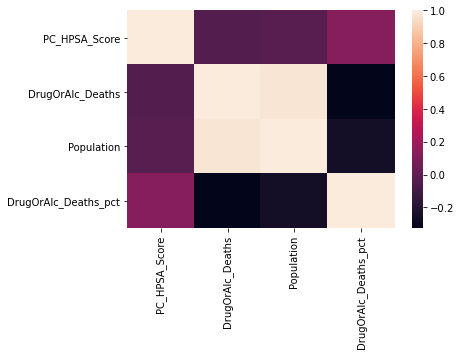

In [98]:
numeric_columns = combined_df_counties.select_dtypes(include=[np.number])

# Calculate correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Display the correlation matrix (optional)
import seaborn as sns

sns.heatmap(correlation_matrix)

In [99]:
correlation_matrix

,PC_HPSA_Score,DrugOrAlc_Deaths,Population,DrugOrAlc_Deaths_pct
PC_HPSA_Score,1.000000,-0.038452,-0.023995,0.124419
DrugOrAlc_Deaths,-0.038452,1.000000,0.974470,-0.325365
Population,-0.023995,0.974470,1.000000,-0.255505
DrugOrAlc_Deaths_pct,0.124419,-0.325365,-0.255505,1.000000


In [ ]:
cleaned_df_nibrs_19

In [29]:
combined_df_cities = cleaned_df_nibrs_19.merge(df_select_cities, how='inner', on='State_City')
combined_df_cities.drop(['State Name', 'HPSA City'], axis=1, inplace=True)
combined_df_cities

,State,City,Population1,Total_Offenses,Crimes_Against_Persons,Crimes_Against_Property,Crimes_Against_Society,Assault_Offenses,Aggravated_Assault,Simple_Assault,...,Sports_Tampering,Pornography/Obscene_Material,Prostitution_Offenses,Prostitution,Assisting_or_Promoting_Prostitution,Purchasing_Prostitution,Weapon_Law_Violations,Year,State_City,PC_HPSA_Score
0,Arizona,Gilbert,253619.0,10589.0,1844.0,6144.0,2601.0,1642.0,157.0,1200.0,...,0.0,47.0,10.0,10.0,0.0,0.0,78.0,2019.0,"Arizona, Gilbert",18.0
1,Arizona,Somerton,16771.0,257.0,70.0,155.0,32.0,57.0,15.0,30.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2019.0,"Arizona, Somerton",16.0
2,Arizona,Yuma,98769.0,7037.0,1110.0,4575.0,1352.0,965.0,309.0,536.0,...,0.0,30.0,2.0,0.0,2.0,0.0,93.0,2019.0,"Arizona, Yuma",0.0
3,Arkansas,Ash Flat,1095.0,86.0,19.0,52.0,15.0,19.0,5.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,"Arkansas, Ash Flat",15.0
4,Arkansas,Augusta,1939.0,119.0,38.0,69.0,12.0,31.0,7.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2019.0,"Arkansas, Augusta",15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,Wisconsin,Sturtevant,6645.0,129.0,19.0,56.0,54.0,17.0,4.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2019.0,"Wisconsin, Sturtevant",6.0
879,Wisconsin,Waupun,11315.0,324.0,32.0,124.0,168.0,19.0,1.0,17.0,...,0.0,2.0,0.0,0.0,0.0,0.0,4.0,2019.0,"Wisconsin, Waupun",7.5
880,Wisconsin,Wausau,38507.0,2438.0,515.0,1007.0,916.0,387.0,110.0,245.0,...,0.0,21.0,2.0,1.0,1.0,0.0,53.0,2019.0,"Wisconsin, Wausau",10.0
881,Wisconsin,Whitewater,14997.0,666.0,101.0,296.0,269.0,68.0,22.0,42.0,...,0.0,8.0,0.0,0.0,0.0,0.0,9.0,2019.0,"Wisconsin, Whitewater",15.0


<AxesSubplot:>

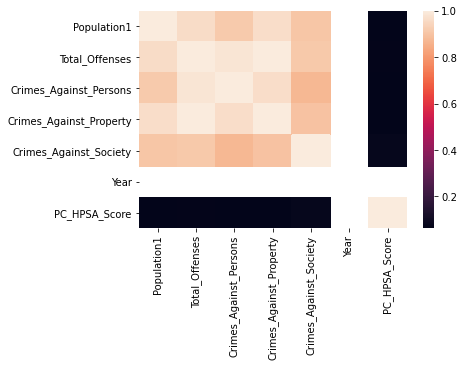

In [97]:
# Select only numeric columns
numeric_columns = combined_df_cities.select_dtypes(include=[np.number])

# Calculate correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Display the correlation matrix (optional)

sns.heatmap(correlation_matrix)

Note: We might want to try generating multiple years worth of data to expand the number of rows in the city dataset. 

In [36]:
print(len(combined_df_cities[combined_df_cities['PC_HPSA_Score']==0]))
len(combined_df_counties[combined_df_counties['PC_HPSA_Score']==0])

20


74

## Adding the 500 Cities Project data, which contains health data on cities including census tract levels. 